# The U2H map 
In this notebook, we demonstrate the application of the "U2H map" introduced in our paper (ArXiv link: https://arxiv.org/abs/2402.05652). Given a snapshot of current velocities and information on the incoming wave spectrum, the U2H map generates the current-induced changes in the significant wave height $h_s$ of deep-water surface gravity waves (SGWs), based on the assumptions listed in section 2 in our paper. 

The current velocities are by default imported from an MITgcm model output, identical to the one in figure 1 in our paper. Users can change the currents to other forms to their liking.

The background wave energy spectrum is by default set to be the same as the example in figure 1 in our paper. Users can modify the background wave energy spectrum to other arbitrary forms in the wavenumber-direction space. 

We also demonstrate the U2H map with the asymptotic expressions assuming highly directional waves. This requires assuming the LHCS model spectrum (described in Appendix B1). Users can vary the angular-width parameter $s$ to investigate the impact of directional spreading on the validity of the asymptotic approximation. 

In [1]:
#Import required packages and constants
import numpy as np
import matplotlib.pyplot as plt
import colorcet as cc
import hwffts #Fast Fourier transform package, which normalizes and shifts the np.fft functions in H.Wang's favorite way. 
from scipy import special   
import pickle
from scipy import integrate
import warnings
pi=np.pi

Defining the incoming wave energy spectrum. By default we assume it takes the same form as figure 1 in our paper, following the LHCS model with parameters $s=10$ and $\theta_p=0$. You can change it to any other spectra you'd like to investigate. 

In [2]:
#Whether or not the incoming wave spectrum follows the LHCS model spectrum described in Appendix B, with the directional-width parameter $s$ assumed to be an integer. 
#By default this is set True, as the default example presented here is the same as figure 1, which satisfies the LHCS with $\theta_p=0, s=10$.
#If your incoming wave spectrum is not LHCS with integer s, then please set isLHCSisimp=False, and determine ncutoff in cell [5]. The demonstration in cell [7] on the asymptotic approximation of the U2H map under the swell limit are not implemented when this is False.  
isLHCSsimp=True

#Parameters for the incoming wave spectra assuming the LHCS model described in Appendix B. Default values correspond to the snapshot shown in Figure 1 of our paper. 
#If not assuming the LHCS model, you can caption out the next lines in this code block and define your own E2D. 
waveT=10.3 #Peak wave period (unit: s)
s=10 #Directional spreading parameter in the LHCS model; larger s correspond to smaller directional spreading
sip = 0.01 #variance of frequency
theta_p=0 #primary angle of wave propagation, measured from the $x$-axis and in the direction of $\bk$. Unit: radians. 

#Other parameters
g=9.806 #Gravity acceleration
Hs0=1 #Background significant wave height (unit: m). This parameter does not affect the outcomes presented in terms of hs/Hs0

#Grid in wavenumber-direction space 
Ndir = 48 #number of grid points in $\theta$
Nf = 32 #number of grid points in frequencies; equivalently, it is the number of grid points in $k$. 
theta = np.linspace(-pi, pi, Ndir) #$\theta$ 
lowf = 0.04118 #Lowest frequency resolved (in Hz)
ffactor = 1.1 #controling the grids in frequency
fp = 1/waveT  #peak frequency (in Hx)
highf=lowf*(ffactor**32)
freq=np.linspace(lowf,highf,Nf)
k=(2*pi*freq)**2/g #Wavenumber $k$ in the unit of m^{-1}. Note 2 pi is needed as f is not angular frequency

#2D grid in $k, \theta$
k2D,theta2D=np.meshgrid(k,theta)
k2D=np.transpose(k2D) #Making indexing intuitive, i.e. E2D[i,j] would refer to E2D at k[i] and theta[j]
theta2D=np.transpose(theta2D)

#Funciton for the distribution in frequency, which is Gaussian. This corresponds to the LHCS model spectrum detailed in Appendix B.
def gaussian_spec(freq, fp, sip):
    frrel = (freq - fp)/sip
    return np.exp(-1.25*(frrel**2))

#E2D, the 2D wave energy spectrum $\mathcal{E}(k,\theta)$ following the paper's notations 
#By default, we set it to follow the LHCS model spectrum detailed in Appendix B. Users can change E2D to any other forms on the (k2D,theta2D) grid.
E2D=gaussian_spec(np.sqrt(g*k2D)/(2*pi), fp, sip)*np.cos((theta2D-theta_p)/2)**(2*s)
#Normalize so that the corresponding background SWH is Hs0
Hs0_r=4*np.sqrt(integrate.trapezoid(integrate.trapezoid(E2D*k2D,x=k,axis=0),x=theta)/g)
E2D=E2D*Hs0**2/Hs0_r**2


Load a set of precomputed current velocity snapshot to be used to compute the U2H map.

You can replace the current velocity field with your own, and recompute the U2H map. To do that without modifying the code cells after this, please format your field so that:  (1) the 2-dimensional variables u,v, which refer to velocity components along $x$ or $y$, are formatted so that u[ix,iy] refers to u evaluated at x1d[ix] and y1d[iy], where x1d or y1d are the equally spaced grids in $x$ or $y$, and (2) the number of grid points of the one-dimensional variables x1d and y1d are even, in order for the fast-Fourier transform package ("hwffts") applied in the code to work. 

In [3]:
f = open('snapshot_uv.pckl', 'rb')
x1d, y1d, u, v = pickle.load(f) #x1d, y1d are the grids in x and y. Unit: meters. u, v are velocity components along x or y. Unit: m/s.
f.close()

Pad $x,y,u,v,h_s$ with zeros in $(x,y)$ space. This is to circumvent artifacts from the non-periodic boundaries in the current's snapshot. 

In [4]:
#Parameter for zero padding
#By default we pad in each direction 100% of the original domain width. A generous padding ensures that the $\hs$ field computed decays to nearly zero at the boundary of the padded domain. 
#The decay of $\hs$ at the boundary of the padded domain was checked a posteriori in the default example presented here; in extreme cases, users may need to adjust the parameter padportion (decreasing for computational time, or increasing to ensure sufficient decay)/
padportion=1 #percentage to pad in x or y in each direction in the periphery. 

#Numerical grids after padding
Nx=len(x1d)
Ny=len(y1d)
Nxtopad=round(Nx*padportion)
Nytopad=round(Ny*padportion)
Nxpad=Nx+2*Nxtopad
Nypad=Ny+2*Nytopad
dx=x1d[1]-x1d[0]
xminpad=x1d[0]-dx*(Nxtopad)
xmaxpad=x1d[-1]+dx*(Nxtopad)
x1dpad=np.linspace(xminpad,xmaxpad,num=Nxpad)
dy=y1d[1]-y1d[0]
yminpad=y1d[0]-dy*(Nytopad)
ymaxpad=y1d[-1]+dy*(Nytopad)
y1dpad=np.linspace(yminpad,ymaxpad,num=Nypad)
upad=np.zeros((Nxpad,Nypad))
upad[Nxtopad:Nxtopad+Nx,Nytopad:Nytopad+Ny]=u
vpad=np.zeros((Nxpad,Nypad))
vpad[Nxtopad:Nxtopad+Nx,Nytopad:Nytopad+Ny]=v
Nxo=Nx #Nxo is the number of grid points in x before zero padding. 
Nyo=Ny
Nxpad=len(x1dpad) #Nxpad is the number of grid points in x after zero padding.
Nypad=len(y1dpad)
#Shift x1d and y1d so that they center at 0, for convenience of the application of hwffts. 
xshift=x1dpad[Nxpad//2-1]
yshift=y1dpad[Nypad//2-1]
x1dpad=x1dpad-xshift
y1dpad=y1dpad-yshift

#Wavenumber for the currents (or Hs), corresponding to the padded domain 
q1_1d=hwffts.k_of_x(x1dpad) #$q_1$
q2_1d=hwffts.k_of_x(y1dpad) #$q_2$
q1_2d,q2_2d=np.meshgrid(q1_1d,q2_1d)
q1_2d=np.transpose(q1_2d) #Make indexing intuitive, i.e. F[i,j] would mean we want q1 at the ith and q2 at the jth.
q2_2d=np.transpose(q2_2d)

#polar coordinate of $\bm{q}$, following the paper's notation
q=np.sqrt(q1_2d**2+q2_2d**2)#wavenumber $q$ of $\bm{q}$
varphi = np.arctan2(q2_2d, q1_2d) #polar angle $\varphi$ of $\bm{q}$.

#Fourier transform of current velocities. The outputs are evaluated at the grid (q1_2d,q2_2d).
ut=hwffts.hwfft2(x1dpad, y1dpad, upad)
vt=hwffts.hwfft2(x1dpad, y1dpad, vpad)

Compute the U2H map.

In [5]:
#A2D, wave action $\mathcal{A}(k,\theta)$, following the paper's notation 
A2D=E2D/np.sqrt(g*k2D) #equation (2.4)

#Compute the transfer operator $\bm{L}$ from equation (3.11)

#$\mathcal{P}(\theta)$ from equation (3.8)  
Pcal=integrate.trapezoid(A2D*k2D**2,x=k,axis=0)

#The cutoff Fourier mode number in the Fourier sum in equation (3.10).  
#In case the LHCS model is assumed with an integer s (default form of this notebook), $p_n=0$ at $n>s$ (equation B3).
if isLHCSsimp:
    ncutoff=s 
    
#In case the LHCS model is not assumed, the parameter ncutoff needs to be input by the user. 
#ncutoff = $set_your_ncutoff_here$

if 'ncutoff' not in globals():
    raise ValueError(
            "Error: Parameter 'ncutoff' (the cutoff Fourier mode number in the Fourier sum in equation (3.10) in the paper) is not defined. Please provide a valid 'ncutoff'. \n"
            "Hints: 'ncutoff' should not be larger than the Nyquist frequency in the angular distribution (i.e. ncutoff \leq Ndir//2-1). Typically for the ocean, ncutoff=40 should already be sufficient to capture the angular distribution of the SGWs."
        )
else: 
         print("Parameter 'ncutoff' is given as %i." % ncutoff)
if ncutoff>Ndir//2-1:
    warnings.warn(
        "Warning: Parameter'ncutoff' is too large compared to Ndir, and the Fourier sum  in equation (3.10) may be numerically unstable. We suggest increasing Ndir or decreasing ncutoff."
        )
    
#Get Fourier coefficients pn ($p_n$ in the paper defined in equation (3.10))
#In this code, we compute pn from a trapezoidal integration. For better computational speed, one can modify so that 
#the computation of pn can use FFT. 
pn=np.zeros(2*ncutoff+1)+1j
nvec=np.arange(-ncutoff,ncutoff+1,1) #Fourier mode number 
for i in np.arange(len(nvec)):
    ni=nvec[i]
    pn[i]=1/(2*pi)*integrate.trapezoid(Pcal*np.exp(-1j*ni*theta),x=theta)        
    
#Split $\hat{\mathbf{L}}(\varphi)$ following equation (3.11) in our paper. 
#The second term in equation (3.11), which is parralel to the wave momentum $\mathbf{P}$:
P1=np.real(2*pi*pn[nvec==1])
P2=-np.imag(2*pi*pn[nvec==1])
LtP1=-32/(g*Hs0**2)*P1
LtP2=-32/(g*Hs0**2)*P2
#The first term in equation (3.11), which is parralel to $\mathbf{e_q^{\perp}):
Lt2=np.zeros([Nxpad,Nypad],dtype=complex)
for iq1 in np.arange(Nxpad):
    for iq2 in np.arange(Nypad):
        varphii=varphi[iq1,iq2]
        Lt2[iq1,iq2]=16/g/(Hs0**2)*np.sum(nvec*(-1j)**np.abs(nvec)*2*pi*pn*(np.exp(1j*nvec*varphii)))
Lt21=-Lt2*np.sin(varphi) #The component along $q_1$
Lt22=Lt2*np.cos(varphi) #The component along $q_2$       
#Sum the two terms in equation (3.11)
Lhat1=(LtP1+Lt21) #$\hat{\bm{L}}(\varphi)$ along $q_1$
Lhat2=(LtP2+Lt22) #$\hat{\bm{L}}(\varphi)$ along $q_2$

#The U2H map
#Linear multiplication in the $(q_1,q_2)$ space; see equation (1.2)
hst=Lhat1*ut+Lhat2*vt #In this code, hst is already normalized by $\bar {H}_s$; following the paper's notation, hst is $\hat{h_s}/\bar {H}_s$
#Inverse Fourier transform
hs=np.real(hwffts.hwifft2(q1_1d, q2_1d, hst))

#So far, the U2H map is conducted on the padded domain, and hs has zero mean over the padded domain. 
#To be consistent with our formulation, i.e., hs is the spatial anomaly over the unpadded domain, 
#We subtract from hs its mean over the unpadded domain.
hs=hs-np.mean(hs[Nxtopad:Nxtopad+Nxo,Nytopad:Nytopad+Nyo])

Parameter 'ncutoff' is given as 10.


Plotting the snapshot of the current speed and the $h_s$ computed from the U2H map. Under default configurations, this corresponds to the panels (a,b) of figure 1 in our paper.

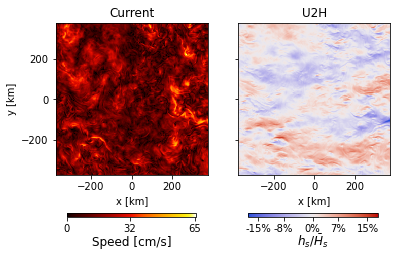

In [6]:
fighs,axhsall=plt.subplots(1,2)
axhs=axhsall.ravel()

hsmax=np.max(np.abs(hs/Hs0))
hsmin=-hsmax

uspeed=np.sqrt(upad**2+vpad**2);
#The 2D fields are transposed for plotting 
imu=axhs[0].pcolor(x1dpad[Nxtopad:Nxtopad+Nxo]/1000,y1dpad[Nytopad:Nytopad+Nyo]/1000,np.transpose(uspeed[Nxtopad:Nxtopad+Nxo,Nytopad:Nytopad+Nyo])*100,cmap=cc.cm.fire) 
imhs=axhs[1].pcolor(x1dpad[Nxtopad:Nxtopad+Nxo]/1000,y1dpad[Nytopad:Nytopad+Nyo]/1000,np.transpose(hs[Nxtopad:Nxtopad+Nxo,Nytopad:Nytopad+Nyo])*100,cmap=cc.cm.coolwarm,vmax=hsmax*100,vmin=hsmin*100) 

axhs[0].set_title('Current' )
axhs[1].set_title(r'U2H')
axhs[0].set_aspect('equal')
axhs[1].set_aspect('equal')
axhs[0].set_xlabel('x [km]')
axhs[1].set_xlabel('x [km]')
axhs[0].set_ylabel('y [km]')
axhs[1].tick_params(labelleft=False)    

#When plotting, we truncate the outcomes back into the unpadded domain in (x,y).
fighs.subplots_adjust(bottom=0.2)
cbar_axhs = fighs.add_axes([0.57, 0.13, 0.3, 0.015]) 
cbar_axhs.set_title(r'$h_s/\bar{H}_s$', y=-8)
cmaptickhs=np.floor(np.min([np.nanmax(hs[Nxtopad:Nxtopad+Nxo,Nytopad:Nytopad+Nyo]/Hs0*100),-np.nanmin(hs[Nxtopad:Nxtopad+Nxo,Nytopad:Nytopad+Nyo]/Hs0*100)])) #set the middle point of the colorbar to be 0
cbarhs=plt.colorbar(imhs,cax=cbar_axhs,ticks=[-cmaptickhs,-cmaptickhs//2, 0, cmaptickhs//2, cmaptickhs],orientation='horizontal',format ='%.0f%%')

cbar_axu = fighs.add_axes([0.15, 0.13, 0.3, 0.015]) 
cbar_axu.set_title('Speed [cm/s]', y=-8)
cmapticku=np.floor(np.max(uspeed)*100) 
cbaru=plt.colorbar(imu,cax=cbar_axu,ticks=[0, cmapticku//2, cmapticku],orientation='horizontal')


If the wave spectrum is LHCS with integer $s$ and centered at $\theta_p=0$, then the next cell block computes the U2H map that uses the asymptotic expression of transfer function $\hat{\mathbf{L}}(\varphi)$ in the limit of large $s$, as shown in equation (5.15) in the paper.

You can change s defined in cell [2] and re-run the notebook, to check that larger s leads to a better agreement between the swell approximation and the original U2H map.

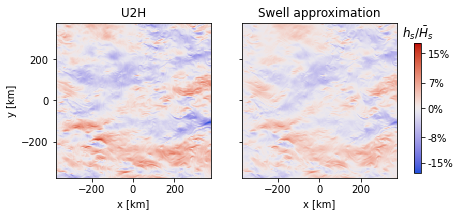

In [7]:
if isLHCSsimp and theta_p==0:
    #L in the swell limit, assuming LHCS centered at theta_p=0 and with integer s
    delta=np.sqrt(2/s) #The parameter $\delta$ representing the support of the angular distribution of wave action, defined in equation (5.9), and related to s via equation (5.13).

    alpha=integrate.trapezoid(integrate.trapezoid(A2D*k2D**2,x=k,axis=0),x=theta) #alpha defined in equation (B2)
    
    Phip=(varphi-pi/2)/delta #$\Phi_{+}$, the branch near $\varphi=\pi/2$ in equation (5.11)
    Phim=(varphi+pi/2)/delta #$\Phi_{-}$, the branch near $\varphi=-\pi/2$ in equation (5.11)

    #The expression for $\hat{\mathbf{L}}(\varphi)$ under large s (or small $\delta$).
    #Following equation (5.15).
    #The amplitude of the imaginary part:
    Lswellimag=16*alpha/(g*Hs0**2)/(delta**2)*(np.sqrt(pi/2))*(Phip*np.exp(-Phip**2/2)*np.heaviside(varphi,0)+Phim*np.exp(-Phim**2/2)*np.heaviside(-varphi,0))
    #The amplitude of the real part:
    Lswellreal=16*alpha/(g*Hs0**2)/(delta**2)*((-np.sqrt(2)*Phip*special.dawsn(Phip/np.sqrt(2))+1)*np.heaviside(varphi,0)+(np.sqrt(2)*Phim*special.dawsn(Phim/np.sqrt(2))-1)*np.heaviside(-varphi,0)) 

    #Projecting onto q1 and q2
    Lswellimag_1=Lswellimag*(-np.sin(varphi))
    Lswellimag_2=Lswellimag*np.cos(varphi)

    Lswellreal_1=Lswellreal*(-np.sin(varphi))
    Lswellreal_2=Lswellreal*np.cos(varphi)

    #Summing up the imaginary and real parts
    Lswell1=Lswellreal_1+1j*Lswellimag_1 #The $\hat{\mathbf{L}}(\varphi)$ under large s, component along q_1
    Lswell2=Lswellreal_2+1j*Lswellimag_2 #The $\hat{\mathbf{L}}(\varphi)$ under large s, component along q_2

    #The U2H map under the large s limit
    #Linear mupltiplication in the (q_1,q_2) space
    hst_swell=Lswell1*ut+Lswell2*vt 
    #Inverse Fourier transform
    hs_swell=np.real(hwffts.hwifft2(q1_1d, q2_1d, hst_swell))
    #subtract from it the mean over the unpadded domain
    hs_swell=hs_swell-np.mean(hs_swell[Nxtopad:Nxtopad+Nxo,Nytopad:Nytopad+Nyo])   
    
    fighsswell,axhsswellall=plt.subplots(1,2)
    axhsswell=axhsswellall.ravel()
    axhsswell[0].pcolor(x1dpad[Nxtopad:Nxtopad+Nxo]/1000,y1dpad[Nytopad:Nytopad+Nyo]/1000,np.transpose(hs[Nxtopad:Nxtopad+Nxo,Nytopad:Nytopad+Nyo])*100,cmap=cc.cm.coolwarm,vmax=hsmax*100,vmin=hsmin*100) 
    axhsswell[1].pcolor(x1dpad[Nxtopad:Nxtopad+Nxo]/1000,y1dpad[Nytopad:Nytopad+Nyo]/1000,np.transpose(hs_swell[Nxtopad:Nxtopad+Nxo,Nytopad:Nytopad+Nyo])*100,cmap=cc.cm.coolwarm,vmax=hsmax*100,vmin=hsmin*100) 
    fighsswell.subplots_adjust(right=0.915)
    cbar_axswell = fighsswell.add_axes([0.955, 0.25, 0.015, 0.45]) 
    cbar_axswell.set_title(r'$h_s/\bar{H}_s$')
    cbar_axswell=plt.colorbar(imhs,cax=cbar_axswell,ticks=[-cmaptickhs,-cmaptickhs//2, 0, cmaptickhs//2, cmaptickhs],format ='%.0f%%')
    axhsswell[0].set_aspect('equal')
    axhsswell[1].set_aspect('equal')
    axhsswell[0].set_xlabel('x [km]')
    axhsswell[1].set_xlabel('x [km]')
    axhsswell[0].set_ylabel('y [km]')
    axhsswell[1].tick_params(labelleft=False)    
    axhsswell[0].set_title(r'U2H')
    axhsswell[1].set_title(r'Swell approximation')
else:
    print('The asymptotic expressions at the swell limit for the U2H map are not implemented for the wave spectrum you defined yet. ')